# Step 0: Roman cities and population estimates of the Roman Empire - data generation

*AIM:* This script generates the dataset of cities of the Roman Empire and their population estimates. 

References: 
1) `Hanson J. W., An urban geography of the Roman world, 100 BC to AD 300. Oxford: Archaeopress; 2016.` http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv
2) `Hanson J. W, Ortman S. G., A systematic method for estimating the populations of Greek and Roman settlements. J Roman Archaeol. 2017;30: 301–324.`


This script was originally published by `Kaše V, Heřmánková P, Sobotková A (2022) Division of labor, specialization and diversity in the ancient Roman cities: A quantitative approach to Latin epigraphy. PLoS ONE 17(6): e0269869. https://doi.org/10.1371/journal.pone.0269869` under a CC BY-SA 4.0 International License. 

https://github.com/sdam-au/social_diversity

The *Past Social Networks Project* adapted the script to fit the needs of the project research agenda.

## Data

**IN**:
1) Cities `http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv`

2) Monuments `http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Monuments_OxREP.csv`

3) Population estimates `HansonOrtmanetal2017_dataset.csv`

4) Roman provinces `https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson`

**OUT**: 

1) Cities `hanson_2016_merged.csv`

2) Cities with population estimates `roman_cities_pop.csv`, `roman_cities_pop.geojson`, `roman_cities_pop.parquet`

3) Roman provinces `pleiades_regions.geojson`



#  Requirements

In [1]:
import requests
import numpy as np
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import io
import os

In [2]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../../figures/" + fig_name + ".eps")
    fig.savefig("../../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

# Data preparation

## Roman Cities merging

Dataset of cities from Hanson 2016

In [3]:
### ROMAN CITIES AS A DATAFRAME
url = "http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv"
response = requests.get(url).text
file_object = io.StringIO(response)
cities_raw = pd.read_csv(file_object)
cities_raw.head(3) 

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...


In [4]:
cities_area = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Areas_OxREP.csv").text))
cities_area.head(3)

,Primary Key,Area,Estimate Basis
0,Hanson2016_1,16,Walls
1,Hanson2016_4,52,Inhabited area
2,Hanson2016_7,130,Walls


In [5]:
len(cities_area)

885

In [6]:
cities_status_raw = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Civic%20Status_OxREP.csv").text))
cities_status_raw.head(3)

,Primary Key,Civic Status,Notes
0,Hanson2016_1,Rights and privileges,libera
1,Hanson2016_4,Rights and privileges,libera
2,Hanson2016_8,Rights and privileges,libera et immunis


In [7]:
cities_status = pd.DataFrame(cities_status_raw.groupby("Primary Key")["Civic Status"].apply(list))
cities_status.head(5)

,Civic Status
Primary Key,
Hanson2016_1,[Rights and privileges]
Hanson2016_1000,[Municipium]
Hanson2016_1001,[Municipium]
Hanson2016_1002,"[Colonia, Municipium]"
Hanson2016_1003,[Municipium]


In [8]:
cities_monuments_raw = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Monuments_OxREP.csv").text))
cities_monuments_raw.head(3)

,Primary Key,Structure
0,Hanson2016_1,Acropolis
1,Hanson2016_1,Agora
2,Hanson2016_1,Temple of Apollo


In [9]:
print(len(cities_monuments_raw))
cities_monuments = pd.DataFrame(cities_monuments_raw.groupby("Primary Key")["Structure"].apply(list))
print(len(cities_monuments))

9472
1208


In [10]:
cities_monuments

,Structure
Primary Key,
Hanson2016_,[Agora?]
Hanson2016_1,"[Acropolis, Agora, Temple of Apollo, Theatre, ..."
Hanson2016_10,"[Acropolis, Gymnasium, Sanctuary of Poseidon, ..."
Hanson2016_100,"[Acropolis, Fountain, Gymnasium, Gymnasium, Hi..."
Hanson2016_1000,[Temple]
...,...
Hanson2016_993,"[Amphitheatre, Basilica, Baths?, Forum, Temple..."
Hanson2016_995,"[Aqueduct, Baths, Forum, Unidentified public b..."
Hanson2016_996,"[Temple, Walls]"


In [11]:
cities = pd.merge(cities_raw, cities_area, on="Primary Key", how="left") 
cities = pd.merge(cities, cities_status, on="Primary Key", how="left")
cities = pd.merge(cities, cities_monuments, on="Primary Key", how="left")
len(cities)

1388

In [12]:
def get_number_of_structures(row):
  try: num = len(row["Structure"])
  except: num = 0
  return num
cities["num_of_structures"] = cities.apply(lambda row: get_number_of_structures(row), axis=1)

In [13]:
os.getcwd()

'/home/au648560/Github/latin_socdiv/scripts/data_generation'

In [14]:
cities.to_csv("../../data/data_generation/hanson_2016_merged.csv")

## Roman cities processing

In [15]:
cities = pd.read_csv("../../data/data_generation/hanson_2016_merged.csv")

In [16]:
### ROMAN CITIES AS A GEODATAFRAME
cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities["Longitude (X)"], cities["Latitude (Y)"]))
cities.drop(columns=["Longitude (X)", "Latitude (Y)"], inplace=True)
cities.head(5)

,Unnamed: 0,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,geometry
0,0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,['Rights and privileges'],"['Acropolis', 'Agora', 'Temple of Apollo', 'Th...",5,POINT (22.93333 38.58333)
1,1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,NaN,NaN,NaN,"['Sanctuary of Apollo Argyieus', 'Sanctuary of...",3,POINT (23.73409 38.08347)
2,2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,NaN,NaN,"['Acropolis', 'Agora', 'Fountain', 'Temple of ...",7,POINT (23.21970 38.45261)
3,3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,['Rights and privileges'],"['Shrine of Aeacus', 'Stadium', 'Temple of Aph...",8,POINT (23.42850 37.75007)
4,4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,NaN,NaN,NaN,"['Acropolis', 'Agora', 'Gymnasium', 'Temple of...",8,POINT (22.35572 38.14795)


In [17]:
### generate an ID (to be used for future merge)
cities["ID"] = cities.apply(lambda row: row["Primary Key"].partition("_")[2], axis=1)
cities.head(3)

,Unnamed: 0,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,geometry,ID
0,0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,['Rights and privileges'],"['Acropolis', 'Agora', 'Temple of Apollo', 'Th...",5,POINT (22.93333 38.58333),1
1,1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,NaN,NaN,NaN,"['Sanctuary of Apollo Argyieus', 'Sanctuary of...",3,POINT (23.73409 38.08347),2
2,2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,NaN,NaN,"['Acropolis', 'Agora', 'Fountain', 'Temple of ...",7,POINT (23.21970 38.45261),3


## Roman provinces

In [18]:
### # pelagios provinces
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = gpd.read_file(url)
pleiades_regions.head(5)

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


In [19]:
#save for future usage
pleiades_regions.to_file('../../data/data_generation/pleiades_regions.geojson', driver='GeoJSON') 

## Population estimate sizes
from Hanson & Ortman 2017

In [20]:
hanson2017 = pd.read_csv("../../data/data_generation/HansonOrtmanetal2017_dataset.csv")

In [21]:
hanson2017.reset_index(inplace=True)
hanson2017.head(5)

,level_0,Unnamed: 0,index,ID,Name,Area (ha),Population,Forum/agoraarea(m2),Streetarea(m2),Streetlength(m),Streetwidth(m),Blockarea(m2)
0,0,0,0,14,Athenae,225,58114,25967.0,NaN,NaN,NaN,NaN
1,1,1,1,19,Cassope,18,1989,NaN,27335.0,4522.0,7.0,9996.0
2,2,2,2,26,Corinthia,241,63700,15905.0,NaN,NaN,NaN,NaN
3,3,3,3,110,Alexandria,972,410535,75000.0,1072216.0,58399.0,21.0,140509.0
4,4,4,4,172,Carthago,343,102170,15000.0,NaN,NaN,NaN,NaN


In [22]:
### total urban population
hanson2017["Population"].sum()

3039375

In [23]:
### clean the "IDs"
hanson2017["ID"] = hanson2017["ID"].astype(str).str.replace(" ", "")

In [24]:
cities_pop = pd.merge(cities, hanson2017, on="ID", how="left")

### Fitting the model for estimating population sizes

There is an equation to calculate population sizes of ancient cities. It is as 
follows:

(1) <i> N = dA<sup>p</sup>  </i>,

where *N* is size of the estimated population, *d* is base coefficient for inhabitants per area, *A* is size of the area in hectares, and exponent *p* makes the hard work of modifying the density per area.

Thus, once we have area size for 885 Roman cities, to estimate their population sizes we just have to have right values for the coefficient *d* and the exponent *p*. And this is exactly what has been produced by Hanson & Ortman in their 2017 article by fitting a model against a diverse sample of Greco-Roman cities for which we have more robust population estimates based on other methods.





In their article, Hanson and Ortman offer the following values for *p* and *d*. 

*p* = 1.34

*d* = 41.84

Using these values, we are able to obtain approximately the same values for population sizes as the ones they publish in the supplementary data to their 2019 article.

In [25]:
### hanson&ortman2019 sample population data:
yd = cities_pop[cities_pop["Population"]>0]["Population"].values
print(list(yd))

[58114.0, 1989.0, 63700.0, 410535.0, 102170.0, 4837.0, 7037.0, 3085.0, 3085.0, 6034.0, 8633.0, 5975.0, 2655.0, 11979.0, 15580.0, 71587.0, 13870.0, 4653.0, 3085.0, 18882.0, 6567.0, 56053.0, 47672.0, 1030.0, 19404.0, 907.0, 7582.0, 23429.0, 6767.0, 7376.0, 17849.0, 9718.0, 8209.0, 5210.0, 6034.0, 36851.0, 6969.0, 9498.0, 1989.0, 17084.0, 15086.0, 33807.0, 4291.0, 3104.0, 4837.0, 16187.0, 7582.0, 4327.0, 38476.0, 28211.0, 46171.0, 40666.0, 9938.0, 6767.0, 3590.0, 7628.0, 4291.0, 41539.0, 17338.0, 6767.0, 13426.0, 14596.0, 6368.0, 5022.0, 6171.0, 2290.0, 1157.0, 7172.0, 9498.0, 9327.0, 2922.0, 1030.0, 12211.0, 7401.0, 15086.0, 35017.0, 9938.0, 6567.0, 2601.0, 3469.0, 2138.0, 6567.0, 4471.0, 26781.0, 4471.0, 5589.0, 3085.0, 7376.0, 2760.0, 923406.0, 5782.0, 9280.0, 7790.0, 907.0, 4916.0, 1718.0, 2290.0, 19667.0, 7790.0, 1062.0, 8209.0, 6567.0, 14841.0, 2828.0, 458.0, 5399.0, 10608.0, 2601.0, 5399.0, 3085.0, 29368.0, 7999.0, 70860.0, 1157.0, 3420.0, 4291.0, 7188.0, 9938.0, 7790.0, 53334.0, 3

In [26]:
### FIRST COARSE MODEL 

### estimates based on p=1.34 and d=41.84:
exp = 1.34 ### to avoid confusion with p values
dens = 41.84 ### to fit data including Rome, alternatively, try: 41.84 (best fitting density coeffecient for a smaple without Rome)
### area data: 
xd = cities_pop[cities_pop["Population"]>0]["Area"].values.round(4)
### estimate 
working_model = list(dens*(xd**exp).round())
print(working_model)

[59370.96000000001, 2008.3200000000002, 65103.04000000001, 421747.2, 104432.64000000001, 4895.280000000001, 7070.960000000001, 3138.0000000000005, 3138.0000000000005, 42383.920000000006, 8786.400000000001, 6066.8, 2635.92, 12175.44, 15857.36, 73178.16, 14100.080000000002, 4727.92, 3138.0000000000005, 19204.56, 6652.56, 57613.68000000001, 48659.920000000006, 1046.0, 19748.480000000003, 669.44, 7698.56, 23848.800000000003, 6861.76, 7489.360000000001, 18158.56, 9874.240000000002, 8326.16, 5271.84, 6066.8, 37614.16, 7070.960000000001, 9665.04, 2008.3200000000002, 17405.440000000002, 15355.28, 34476.16, 4351.360000000001, 3138.0000000000005, 4895.280000000001, 16359.44, 7698.56, 7489.360000000001, 39162.240000000005, 28744.08, 46986.32000000001, 41421.600000000006, 10083.44, 6861.76, 3640.0800000000004, 7698.56, 4351.360000000001, 42383.920000000006, 17656.480000000003, 15606.320000000002, 13639.840000000002, 14853.2, 6443.360000000001, 5104.4800000000005, 6276.000000000001, 460.24, 1171.52

In [27]:
from scipy.stats import pearsonr as corr
corr(working_model, yd)


PearsonRResult(statistic=0.9986874516926364, pvalue=1.3078781126438977e-160)

Ok, it is quite good.  But it also somehow overestimates some values. Let's try find a better fitting model, perhaps just by including more decimal numbers.

Let's turn to least-squares.


In [28]:
RSS_list = []
exp_values = np.linspace(1.33,1.35, 10001)
for exp in exp_values: ### for each from 1001 values of exp (or: p) between 1.33 and 1.35:
  y_model = dens*(xd**exp) ## tune the model
  RSS = sum(np.square(y_model - yd)) # calculate RSS
  RSS_list.append(RSS) # add it to the list of all RSS
RSS_array = np.array(RSS_list)

### now we have a more precise exponent
exp = exp_values[np.where(RSS_array==min(RSS_array))][0]
exp

1.336068

In [29]:
### let's make the same for the density coefficient:

RSS_list = []
dens_values = np.linspace(41,42, 10001)
for dens in dens_values: ### for each from 1001 values of exp (or: p) between 1.33 and 1.35:
  y_model = dens*(xd**exp) ## tune the model
  RSS = sum(np.square(y_model - yd)) # calculate RSS
  RSS_list.append(RSS) # add it to the list of all RSS
RSS_array = np.array(RSS_list)

### now we have a more precise exponent
dens = dens_values[np.where(RSS_array==min(RSS_array))][0]
dens

41.8398

In [30]:
y_model_fitted = dens*(xd**exp)
y_model_fitted = y_model_fitted.round()
print(list(y_model_fitted))

[58112.0, 1989.0, 63698.0, 410502.0, 102074.0, 4837.0, 6969.0, 3086.0, 3086.0, 41538.0, 8633.0, 5976.0, 2601.0, 11979.0, 15580.0, 71584.0, 13870.0, 4653.0, 3086.0, 18882.0, 6567.0, 56393.0, 47670.0, 1030.0, 19404.0, 673.0, 7582.0, 23429.0, 6767.0, 7376.0, 17849.0, 9718.0, 8209.0, 5210.0, 5976.0, 36851.0, 6969.0, 9498.0, 1989.0, 17084.0, 15086.0, 33806.0, 4291.0, 3086.0, 4837.0, 16077.0, 7582.0, 7376.0, 38397.0, 28210.0, 46036.0, 40589.0, 9938.0, 6767.0, 3590.0, 7582.0, 4291.0, 41538.0, 17338.0, 15332.0, 13391.0, 14596.0, 6368.0, 5022.0, 6171.0, 458.0, 1157.0, 7172.0, 9498.0, 12211.0, 2922.0, 1030.0, 12211.0, 2290.0, 15086.0, 35016.0, 9938.0, 6567.0, 2601.0, 3420.0, 2138.0, 6567.0, 4471.0, 26781.0, 4471.0, 5589.0, 3086.0, 7376.0, 2760.0, 923313.0, 5589.0, 9280.0, 6368.0, 907.0, 4837.0, 1700.0, 2290.0, 14596.0, 4837.0, 1030.0, 8209.0, 6567.0, 14841.0, 2760.0, 458.0, 5399.0, 10608.0, 2290.0, 5399.0, 3086.0, 19666.0, 7999.0, 37159.0, 788.0, 3420.0, 4291.0, 7172.0, 9938.0, 7790.0, 53332.0, 

(0.0, 100000.0)

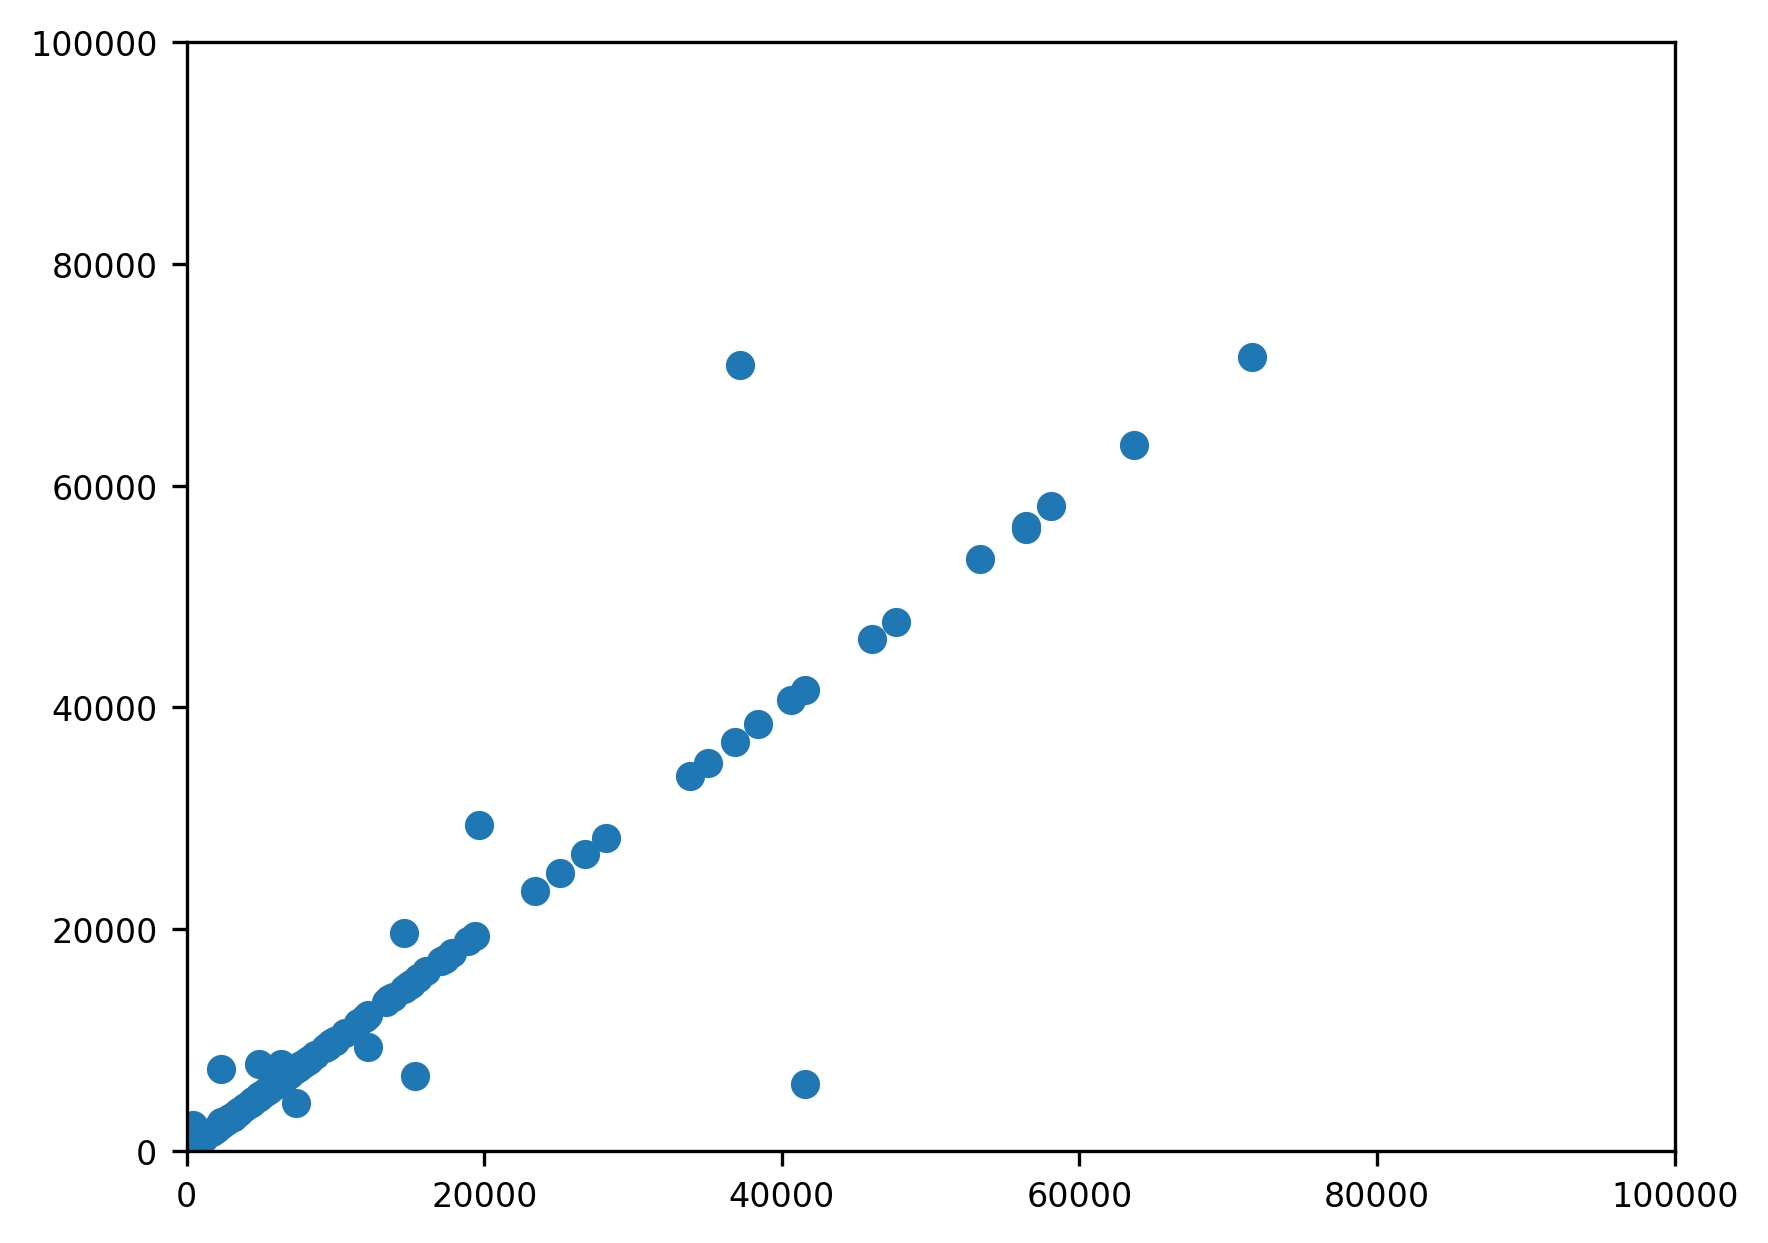

In [31]:
plt.scatter(y_model_fitted, yd)
plt.xlim(0, 100000)
plt.ylim(0, 100000)

Ok, the correlation is almost the same as above, but now we do not overestimate so much. Let's apply it to the dataset as a whole.

### Applying population estimates to the whole dataset

Let's repeat the formula for estimating population sizes

(1) <i> N = dA<sup>p</sup>  </i>,

where *N* is size of the estimated population, *d* is base coefficient for inhabitants per area, *A* is size of the area in hectares, and exponent *p* makes the hard work of modifying the density per area. To avoid confussion, here we use `dens` instead of *d* and `exp` instead of `p`

In [32]:
exp = 1.336068 ### see above
dens = 41.8398 ### see above
def get_pop_est(row):
    area = row["Area"]
    try: 
        pop_est = round(dens * (area**exp), 0)
        if math.isnan(area):
            pop_est = 1000
    except: 
        pop_est = 1000
    return pop_est
cities_pop["pop_est"] = cities_pop.apply(lambda row: get_pop_est(row), axis=1)

In [33]:
cities_pop.columns

Index(['Unnamed: 0_x', 'Primary Key', 'Ancient Toponym', 'Modern Toponym',
       'Province', 'Country', 'Barrington Atlas Rank',
       'Barrington Atlas Reference', 'Start Date', 'End Date',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'geometry', 'ID', 'level_0',
       'Unnamed: 0_y', 'index', 'Name', 'Area (ha)', 'Population',
       'Forum/agoraarea(m2)', 'Streetarea(m2)', 'Streetlength(m)',
       'Streetwidth(m)', 'Blockarea(m2)', 'pop_est'],
      dtype='object')

In [34]:
try:cities_pop.drop(['Name', 'Area (ha)',
       'Forum/agoraarea(m2)', 'Streetarea(m2)', 'Streetlength(m)',
      'Streetwidth(m)', 'Blockarea(m2)',], axis=1, inplace=True)
except: pass

In [35]:
cities_pop.rename({"Population":"pop_sample"}, axis=1, inplace=True)

In [36]:
def get_pop_diff(row):
    try: return abs(row["pop_sample"] / row["pop_est"])
    except: return 0
cities_pop["pop_diff"] = cities_pop.apply(lambda row: get_pop_diff(row), axis=1)
try: cities_pop.drop("Unnamed: 0_x", axis=1, inplace=True)
except: pass
cities_pop.sort_values("pop_diff", ascending=False).head(10)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,Structure,num_of_structures,geometry,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff
673,Hanson2016_674,Noviodunum (Germania Superior),Nyon,Germania Superior,Switzerland,4 or 5,18 D3,-49,NaN,Bedon 2001; Bedon et al 1988; BNP; Cornell and...,...,"['Basilica', 'Baths', 'Forum', 'Forum', 'Macel...",8,POINT (6.23839 46.38083),674,65.0,65.0,65.0,2290.0,458.0,5.000000
775,Hanson2016_776,Herculaneum,Ercolano,Italia (I Latium and Campania),Italy,3,44 F4,-600,79.0,Beloch 1880; Bispham 2007; de Ligt 2012; DGRG;...,...,"['Arch', 'Arch', 'Basilica', 'Baths', 'Baths',...",14,POINT (14.34714 40.80586),776,73.0,73.0,73.0,7401.0,2290.0,3.231878
1161,Hanson2016_1162,Thessalonica,Thessaloniki,Macedonia,Greece,1,50 C3,-316,NaN,Cohen 1995; McEvedy 2011; Nelis-Clément and Ro...,...,"['Acropolis', 'Agora', 'Arch', 'Arch of Galeri...",17,POINT (22.94554 40.63775),1162,112.0,112.0,112.0,70860.0,37159.0,1.906940
1047,Hanson2016_1048,Brixia,Brescia,Italia (X Venetia et Histria),Italy,2,39 G2,-89,NaN,Beloch 1880; Cornell and Mathews 1982; de Ligt...,...,"['Basilica', 'Forum', 'Sanctuary', 'Temple', ""...",8,POINT (10.21984 45.53941),1048,98.0,98.0,98.0,7790.0,4837.0,1.610502
1157,Hanson2016_1158,Pella (Macedonia),Pella,Macedonia,Greece,2,50 C3,-413,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,"['Acropolis', 'Agora', 'Sanctuary of Aphrodite...",8,POINT (22.52564 40.76004),1158,110.0,110.0,110.0,29368.0,19666.0,1.493339
1170,Hanson2016_1171,Cuicul,Djemila,Mauretania Caesariensis,Algeria,3,31 D4,96,NaN,BNP; DGRG; Lepelley 1979-1981; PECS; Quinn and...,...,"['Aqueduct', 'Arch', 'Arch of Caracalla', 'Bas...",19,POINT (5.73573 36.32049),1171,113.0,113.0,113.0,1157.0,788.0,1.468274
342,Hanson2016_343,Iluro,Mataró,Baetica,Spain,3,26 F5,-100,NaN,Brunt 1971; Carreras Monfort 1995-1996; Cornel...,...,"['Baths', 'Forum', 'Fountain', 'Urban grid']",4,POINT (-4.70667 36.82261),343,25.0,25.0,25.0,907.0,673.0,1.347697
1044,Hanson2016_1045,Aquileia,Aquileia,Italia (X Venetia et Histria),Italy,2,19 F4,-181,NaN,Beloch 1880; Beloch 1886; Bispham 2007; Cornel...,...,"['Amphitheatre', 'Basilica', 'Baths', 'Baths (...",18,POINT (13.36705 45.76527),1045,97.0,97.0,97.0,19667.0,14596.0,1.347424
1020,Hanson2016_1021,Placentia,Piacenza,Italia (VIII Aemilia),Italy,2,39 F3,-218,NaN,Beloch 1880; Bispham 2007; Cornell and Mathews...,...,"['Amphitheatre', 'Capitolium', 'Forum?', 'Mace...",7,POINT (9.69312 45.05239),1021,92.0,92.0,92.0,7790.0,6368.0,1.223304
1132,Hanson2016_1133,Sagalassus,Aglasun,Lycia et Pamphylia,Turkey,2,65 E2,-323,NaN,BNP; DGRG; Hanson 2011; Jones 1937; PECS; Sear...,...,"['Acropolis', 'Agora', 'Agora', 'Baths', 'Boul...",18,POINT (30.51919 37.67674),1133,107.0,107.0,107.0,2601.0,2290.0,1.135808


In [37]:
### how many city inhabitants we have
cities_pop["pop_est"].sum()

10159670.0

In [38]:
def normalize_pop_est(pop_est):
    """if smaller than 1000, make 1000"""
    if pop_est < 1000:
        pop_est = 1000
    return pop_est
cities_pop["pop_est"] = cities_pop["pop_est"].apply(normalize_pop_est)

In [39]:
cities_pop["pop_est"].sum()

10214337.0

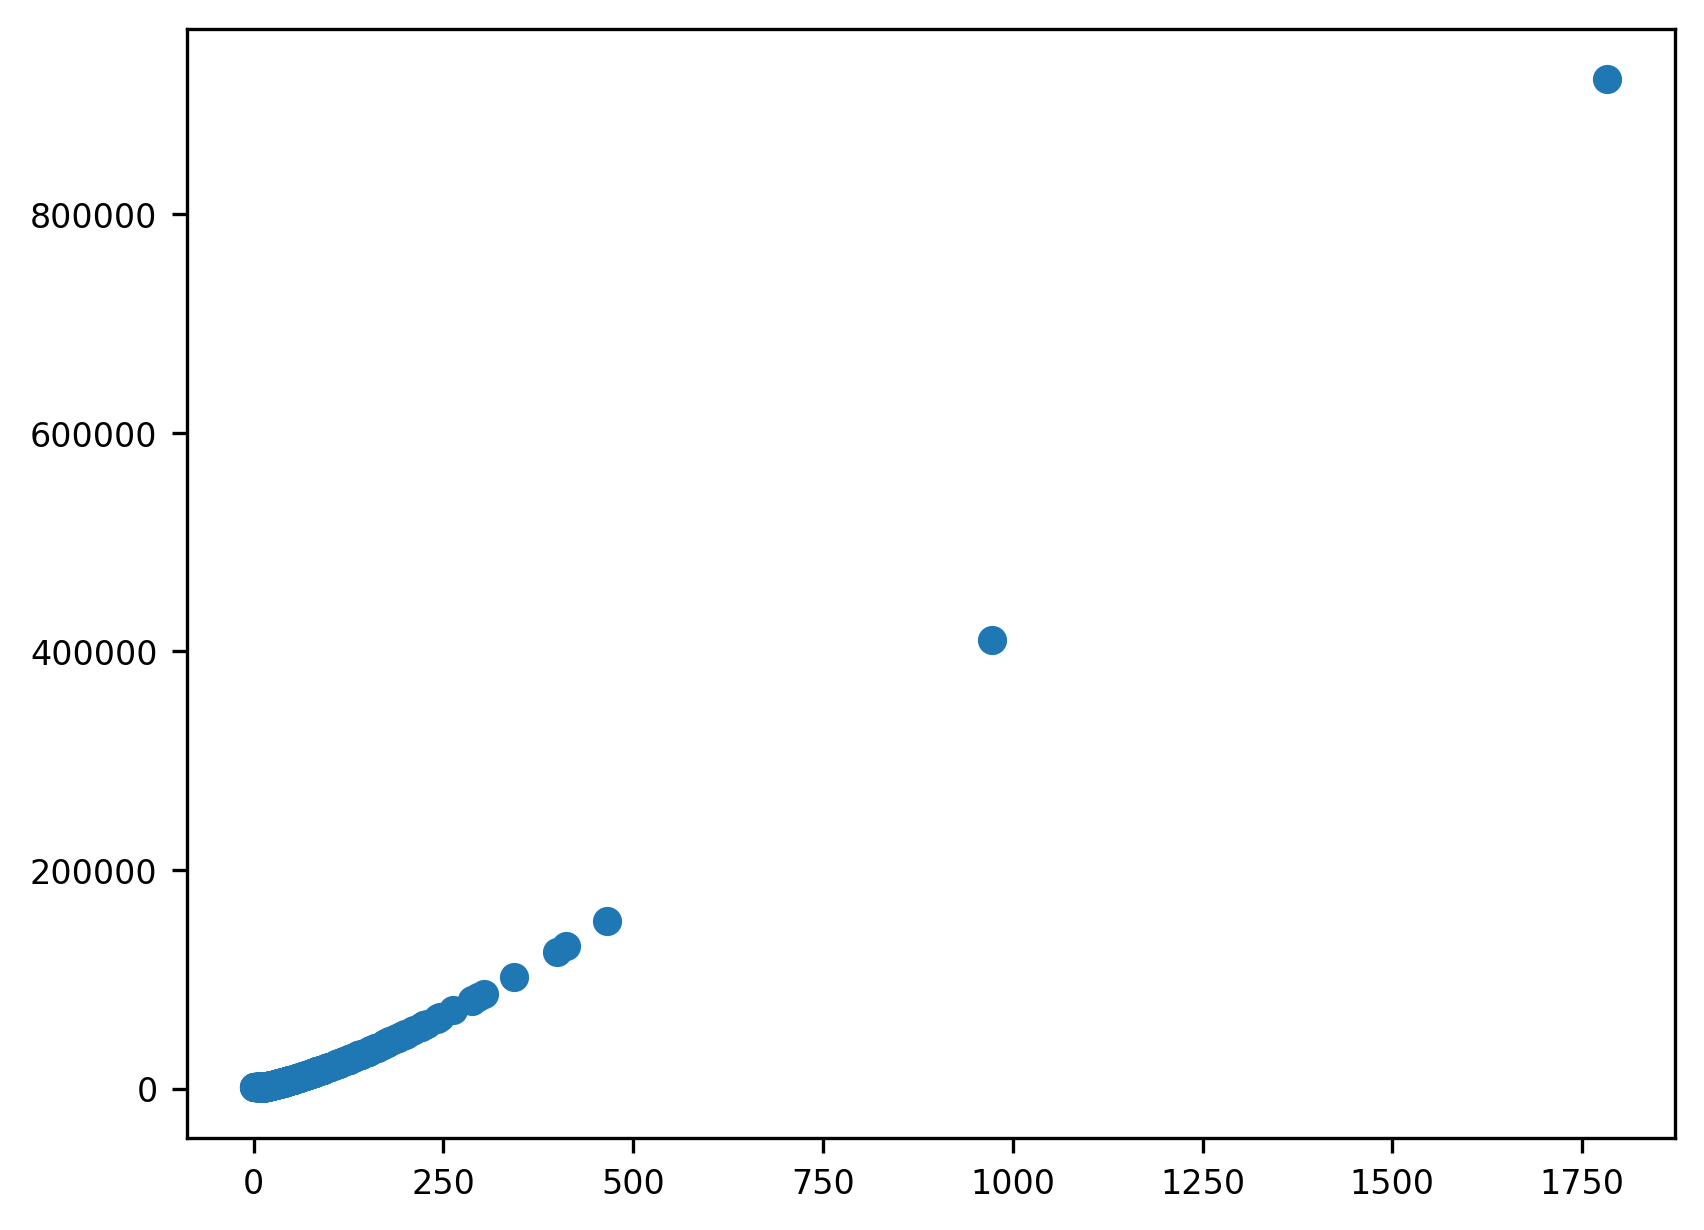

In [40]:
plt.scatter(cities_pop["Area"], cities_pop["pop_est"])

In [41]:
cities_pop.to_csv("../../data/data_generation/roman_cities_pop.csv")

In [42]:
cities_pop.to_file("../../data/data_generation/roman_cities_pop.geojson", driver="GeoJSON")